<table align="center" width=150%>
    <tr>
        <td>
            <div align="center">
                <font color="#21618C" size=8px>
                    <b> Legal Text Summarization <br>
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

This notebook explores the experimentation of implementing the pre-trained long-t5-tglobal-base, GPT-2 and llama-3.2-1B models to develop a practical automatic legal text summarization tool using dataset from the Hugging Face platform.
For the code implementation, resource guides from Hugging Face website was referred (Summarization, n.d.)

###Set up

In [ ]:
!pip install transformers datasets torch rouge-score streamlit evaluate

###Import necessary libraries

In [ ]:
import torch
import evaluate
from transformers import AutoTokenizer, LongT5ForConditionalGeneration
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast
import streamlit as st
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import AdamW, get_scheduler

###Loading the dataset

In [ ]:
# Load the Legal Text Summarization dataset from Hugging Face
dataset = load_dataset('AjayMukundS/Legal_Text_Summarization-llama2')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/494 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/11.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7773 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['judgement', 'dataset_name', 'summary', 'text'],
        num_rows: 7773
    })
    test: Dataset({
        features: ['judgement', 'dataset_name', 'summary', 'text'],
        num_rows: 200
    })
})

In [ ]:
from google.colab import drive
import pandas as pd
# Load the Legal Text Summarization dataset from Hugging Face
train_dataset = load_dataset('AjayMukundS/Legal_Text_Summarization-llama2', split='train')
# Convert to Pandas DataFrame
train_df = pd.DataFrame(train_dataset)
train_df.head()

,judgement,dataset_name,summary,text
0,Appeal No. LXVI of 1949.\nAppeal from the High...,IN-Abs,The charge created in respect of municipal pro...,<s>[INST] Summarize the following judgement: A...
1,Civil Appeal No.94 of 1949.\n107 834 Appeal fr...,IN-Abs,"An agreement for a lease, which a lease is by ...",<s>[INST] Summarize the following judgement: C...
2,"iminal Appeal No. 40 of 1951, 127 Appeal from ...",IN-Abs,"The question whether a Magistrate is ""personal...",<s>[INST] Summarize the following judgement: i...
3,Appeal No. 388 of 1960.\nAppeal by special lea...,IN-Abs,The appellant was a member of a joint Hindu fa...,<s>[INST] Summarize the following judgement: A...
4,Appeal No. 198 of 1954.\nAppeal from the judgm...,IN-Abs,The appellant was the Ruler of the State of Ba...,<s>[INST] Summarize the following judgement: A...


In [ ]:
# Load the Legal Text Summarization dataset from Hugging Face
test_dataset = load_dataset('AjayMukundS/Legal_Text_Summarization-llama2', split='test')
# Convert to Pandas DataFrame
test_df = pd.DataFrame(test_dataset)
test_df.head()

,judgement,dataset_name,summary,text
0,Appeal No. 101 of 1959.\nAppeal by special lea...,IN-Abs,The appellants who are displaced persons from ...,<s>[INST] Summarize the following judgement: A...
1,Appeal No. 52 of 1957.\nAppeal from the judgme...,IN-Abs,The appellants and the respondents were owners...,<s>[INST] Summarize the following judgement: A...
2,Appeals Nos. 45 and 46 of 1959.\nAppeal by spe...,IN-Abs,The respondents firm claimed exemption from Sa...,<s>[INST] Summarize the following judgement: A...
3,ION: Criminal Appeal 89 of 1961.\nAppeal by sp...,IN-Abs,The appellant was tried for murder.\nThe facts...,<s>[INST] Summarize the following judgement: I...
4,Civil Appeal No. 50 of 1961.\nAppeal by specia...,IN-Abs,"S, employed by the appellant as a cross cutter...",<s>[INST] Summarize the following judgement: C...


In [ ]:
drive.mount('/content/drive')
train_df.to_parquet('/content/drive/MyDrive/Adv NLP/AT3/legal_text/train_dataset.parquet')
test_df.to_parquet('/content/drive/MyDrive/Adv NLP/AT3/legal_text/test_dataset.parquet')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###LongT5

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the LongT5 model and tokenizer
model_name = "google/long-t5-tglobal-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
long_t5_model = LongT5ForConditionalGeneration.from_pretrained(model_name).to(device)
# Enable gradient checkpointing to save memory
long_t5_model.gradient_checkpointing_enable()

config.json:   0%|          | 0.00/851 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Tokenize the data
def preprocess_function(examples):
    inputs = [doc for doc in examples['text']]
    model_inputs = tokenizer(inputs, max_length=1024, padding='max_length', truncation=True, return_tensors="pt")

    # Tokenize targets (summaries)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['summary'], max_length=300, padding='max_length', truncation=True, return_tensors="pt")  # Assuming 'summary' is the target field

    model_inputs["labels"] = labels["input_ids"]
    # Move inputs to the correct device
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/7773 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['judgement', 'dataset_name', 'summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7773
    })
    test: Dataset({
        features: ['judgement', 'dataset_name', 'summary', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
})

In [ ]:
# Create DataLoader
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Define optimizer
optimizer = AdamW(long_t5_model.parameters(), lr=1e-5)
# Set up learning rate scheduler
num_training_steps = len(train_dataloader) * 10  # 10 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
# Evaluation metric (ROUGE)
rouge = evaluate.load('rouge')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4860 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1080: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch 1 finished. Training Loss: 2.9623731519459695
Epoch 1 finished. Validation Loss: 1.9864181922032282
Epoch 2 finished. Training Loss: 2.482885567494381
Epoch 2 finished. Validation Loss: 1.8982141934908354
Epoch 3 finished. Training Loss: 2.2665053211121893
Epoch 3 finished. Validation Loss: 1.867363718839792
Epoch 4 finished. Training Loss: 2.200163110048192
Epoch 4 finished. Validation Loss: 1.8431808123221765
Epoch 5 finished. Training Loss: 2.1495031643306275
Epoch 5 finished. Validation Loss: 1.8270452389350305
Epoch 6 finished. Training Loss: 2.1169762569690436
Epoch 6 finished. Validation Loss: 1.820274463066688
Epoch 7 finished. Training Loss: 2.099715048884168
Epoch 7 finished. Validation Loss: 1.815581174997183
Epoch 8 finished. Training Loss: 2.0811041662231884
Epoch 8 finished. Validation Loss: 1.8101544746985803
Epoch 9 finished. Training Loss: 2.0746133177859303
Epoch 9 finished. Validation Loss: 1.8070507599757268
Epoch 10 finished. Training Loss: 2.0703023826634444

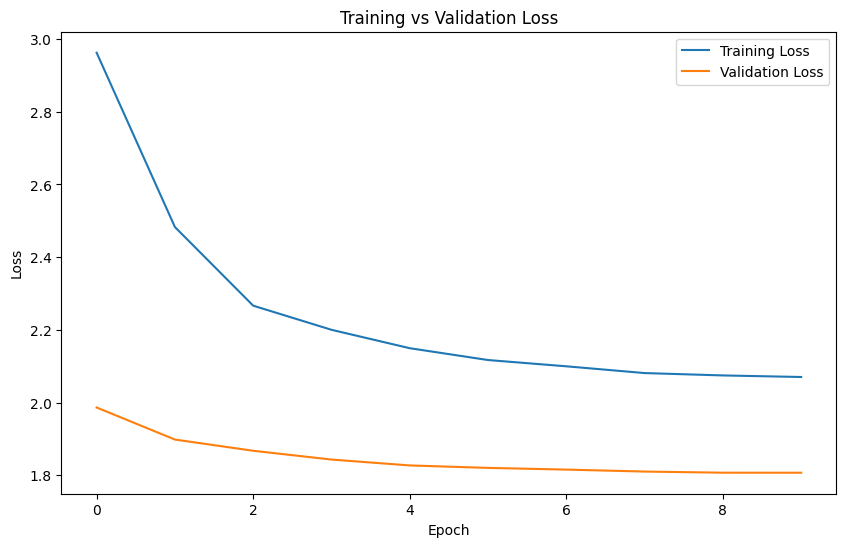

In [ ]:
# Lists to store the training and validation losses for plotting
train_losses = []
val_losses = []

# Training Loop
epochs = 10
progress_bar = tqdm(range(num_training_steps))

long_t5_model.train()

for epoch in range(epochs):
    train_loss = 0
    long_t5_model.train()
    for batch in train_dataloader:
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = long_t5_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(long_t5_model.parameters(), max_norm=1.0)
        # Optimizer step
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Accumulate train loss
        train_loss += loss.item()
        progress_bar.update(1)

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} finished. Training Loss: {avg_train_loss}")

    # Evaluation Loop (Validation)
    long_t5_model.eval()
    val_loss = 0
    decoded_preds = []
    decoded_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = long_t5_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Generate predictions
            predictions = long_t5_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=300)

            # Decode predictions and references
            decoded_pred = tokenizer.batch_decode(predictions, skip_special_tokens=True)
            decoded_label = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds.extend(decoded_pred)
            decoded_labels.extend(decoded_label)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} finished. Validation Loss: {avg_val_loss}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
# ROUGE Evaluation on Test Data after training
long_t5_model.eval()
test_decoded_preds = []
test_decoded_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Generate predictions for test data
        predictions = long_t5_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=300)

        # Decode predictions and references
        decoded_pred = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_label = tokenizer.batch_decode(labels, skip_special_tokens=True)

        test_decoded_preds.extend(decoded_pred)
        test_decoded_labels.extend(decoded_label)

# Compute ROUGE score on the entire test dataset
test_rouge_score = rouge.compute(predictions=test_decoded_preds, references=test_decoded_labels)
print(f"Test Data ROUGE Scores: {test_rouge_score}")

Test Data ROUGE Scores: {'rouge1': 0.47656222887414934, 'rouge2': 0.21746658844235678, 'rougeL': 0.2904817094086083, 'rougeLsum': 0.28987918409364316}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
output_dir = '/content/drive/MyDrive/Adv NLP/AT3/models/fine_tuned_long_t5_model'
long_t5_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer saved to /content/drive/MyDrive/Adv NLP/AT3/models/fine_tuned_long_t5_model


###GPT-2

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the GPT-2 model and tokenizer
gpt2_model_name = "gpt2"
gpt_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Tokenize the data
# GPT-2 doesn't have a padding token, so we need to add one
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
gpt2_model.config.pad_token_id = gpt_tokenizer.eos_token_id
def preprocess_function(examples):
    inputs = [doc for doc in examples['text']]
    model_inputs = gpt_tokenizer(inputs, max_length=512, padding='max_length', truncation=True, return_tensors="pt")

    # GPT-2 uses input text as labels (same as inputs for language modeling)
    model_inputs["labels"] = model_inputs["input_ids"].clone()
    return {k: v.to(device) for k, v in model_inputs.items()}

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/7773 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Create DataLoader
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
# Define optimizer
optimizer = AdamW(gpt2_model.parameters(), lr=1e-5)

# Set up learning rate scheduler
num_training_steps = len(train_dataloader) * 10  # 10 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
# Evaluation metric (ROUGE)
rouge = evaluate.load('rouge')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<ipython-input-8-238ee4540ac6>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  0%|          | 0/9720 [00:00<?, ?it/s]

<ipython-input-8-238ee4540ac6>:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 1 finished. Training Loss: 3.6009874616140203


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 1 finished. Validation Loss: 3.232077054977417


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 2 finished. Training Loss: 3.548016889105118


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 2 finished. Validation Loss: 3.2080713272094727


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 3 finished. Training Loss: 3.4974207193763167


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 3 finished. Validation Loss: 3.186920394897461


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 4 finished. Training Loss: 3.455731848630395


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 4 finished. Validation Loss: 3.1689849948883055


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 5 finished. Training Loss: 3.4231958271544656


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 5 finished. Validation Loss: 3.1541284465789796


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 6 finished. Training Loss: 3.397426389862971


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 6 finished. Validation Loss: 3.1413261127471923


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 7 finished. Training Loss: 3.374237449571429


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 7 finished. Validation Loss: 3.1304977416992186


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 8 finished. Training Loss: 3.3551865342713185


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 8 finished. Validation Loss: 3.1207705879211427


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 9 finished. Training Loss: 3.3397180739744208


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 9 finished. Validation Loss: 3.1125474166870117


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Epoch 10 finished. Training Loss: 3.3262526388030973


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Epoch 10 finished. Validation Loss: 3.1050515747070313


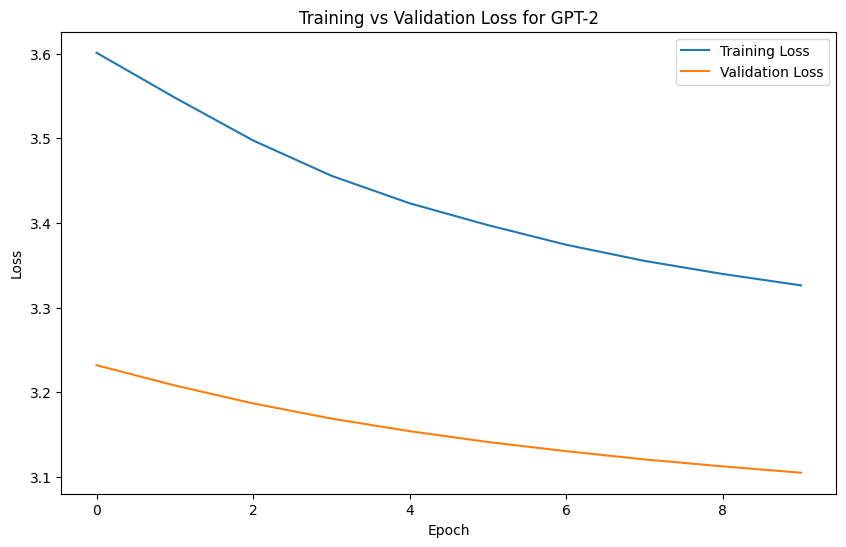

In [ ]:
from torch.cuda.amp import autocast, GradScaler

# Lists to store the training and validation losses for plotting
train_losses = []
val_losses = []

# Define a gradient scaler for mixed precision training
scaler = GradScaler()
# Enable gradient checkpointing to reduce memory usage
gpt2_model.config.use_cache = False
gpt2_model.gradient_checkpointing_enable()
# Training Loop
epochs = 10
accumulation_steps = 4  # Accumulate gradients over 4 batches to simulate a larger batch size
progress_bar = tqdm(range(num_training_steps))

gpt2_model.train()

for epoch in range(epochs):
    train_loss = 0
    gpt2_model.train()

    for i, batch in enumerate(train_dataloader):
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass with mixed precision
        with autocast():
            outputs = gpt2_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps  # Normalize loss for gradient accumulation

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient accumulation: only update weights after every 'accumulation_steps' steps
        if (i + 1) % accumulation_steps == 0:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(gpt2_model.parameters(), max_norm=1.0)
            # Optimizer step and update scaler
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            lr_scheduler.step()

        # Accumulate train loss
        train_loss += loss.item() * accumulation_steps  # Undo normalization for logging
        progress_bar.update(1)

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} finished. Training Loss: {avg_train_loss}")

    # Evaluation Loop (Validation)
    gpt2_model.eval()
    val_loss = 0
    decoded_preds = []
    decoded_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = gpt2_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Generate predictions
            predictions = gpt2_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=300)

            # Decode predictions and references
            decoded_pred = gpt_tokenizer.batch_decode(predictions, skip_special_tokens=True)
            decoded_label = gpt_tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds.extend(decoded_pred)
            decoded_labels.extend(decoded_label)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} finished. Validation Loss: {avg_val_loss}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss for GPT-2")
plt.legend()
plt.show()

In [ ]:
# ROUGE Evaluation on Test Data after training
gpt2_model.eval()
test_decoded_preds = []
test_decoded_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Generate predictions for test data
        predictions = gpt2_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=300)

        # Decode predictions and references
        decoded_pred = gpt_tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_label = gpt_tokenizer.batch_decode(labels, skip_special_tokens=True)

        test_decoded_preds.extend(decoded_pred)
        test_decoded_labels.extend(decoded_label)

# Compute ROUGE score on the entire test dataset
test_rouge_score = rouge.compute(predictions=test_decoded_preds, references=test_decoded_labels)
print(f"Test Data ROUGE Scores: {test_rouge_score}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Test Data ROUGE Scores: {'rouge1': 0.7661949745699432, 'rouge2': 0.7655977967474166, 'rougeL': 0.7661777827491911, 'rougeLsum': 0.7661411447345153}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
output_dir = '/content/drive/MyDrive/Adv NLP/AT3/models/fine_tuned_gpt2_model'
gpt2_model.save_pretrained(output_dir)
gpt_tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

Mounted at /content/drive
Model and tokenizer saved to /content/drive/MyDrive/Adv NLP/AT3/models/fine_tuned_gpt2_model


###Llama-3

In [ ]:
!pip install huggingface_hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from huggingface_hub import HfApi

# Ensure you're logged in or use your Hugging Face token here
hf_token = "************"

llama_model_name = "meta-llama/Llama-3.2-1B"

# Pass the token directly
llama_tokenizer = PreTrainedTokenizerFast.from_pretrained(llama_model_name)
llama_model = LlamaForCausalLM.from_pretrained(llama_model_name).to(device)

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
# Tokenize the data
llama_tokenizer.pad_token = llama_tokenizer.eos_token

def preprocess_function(examples):
    inputs = [doc for doc in examples['text']]
    model_inputs = llama_tokenizer(inputs, max_length=512, padding='max_length', truncation=True, return_tensors="pt")
    model_inputs["labels"] = model_inputs["input_ids"].clone()
    return {k: v.to(device) for k, v in model_inputs.items()}

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/7773 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Create DataLoader
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8)

In [ ]:
from torch.cuda.amp import autocast, GradScaler
# Define optimizer
optimizer = AdamW(llama_model.parameters(), lr=1e-5)

# Set up learning rate scheduler
num_training_steps = len(train_dataloader) * 10  # 10 epochs
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Evaluation metric (ROUGE)
rouge = evaluate.load('rouge')

# Gradient scaling and training setup
scaler = GradScaler()
llama_model.gradient_checkpointing_enable()
llama_model.config.use_cache = False  # Disable caching for gradient checkpointing

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<ipython-input-16-06186f2c470d>:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


  0%|          | 0/9720 [00:00<?, ?it/s]

<ipython-input-17-6c07b519194e>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch 1 finished. Training Loss: 2.2829749831937467


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 1 finished. Validation Loss: 2.250805320739746
Epoch 2 finished. Training Loss: 2.230886497615296


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 2 finished. Validation Loss: 2.2015006160736084
Epoch 3 finished. Training Loss: 2.1767639439292403


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 3 finished. Validation Loss: 2.167146711349487
Epoch 4 finished. Training Loss: 2.135354400294308


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 4 finished. Validation Loss: 2.1334926414489748
Epoch 5 finished. Training Loss: 2.0943088855272456


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 5 finished. Validation Loss: 2.1085682106018067
Epoch 6 finished. Training Loss: 2.0709204936223755


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 6 finished. Validation Loss: 2.096794295310974
Epoch 7 finished. Training Loss: 2.058171883409406


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 7 finished. Validation Loss: 2.0887405347824095
Epoch 8 finished. Training Loss: 2.048327607750402


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 8 finished. Validation Loss: 2.0819366979599
Epoch 9 finished. Training Loss: 2.0399284538172893


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 9 finished. Validation Loss: 2.0748376989364625
Epoch 10 finished. Training Loss: 2.027311255289203


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Epoch 10 finished. Validation Loss: 2.063774280548096


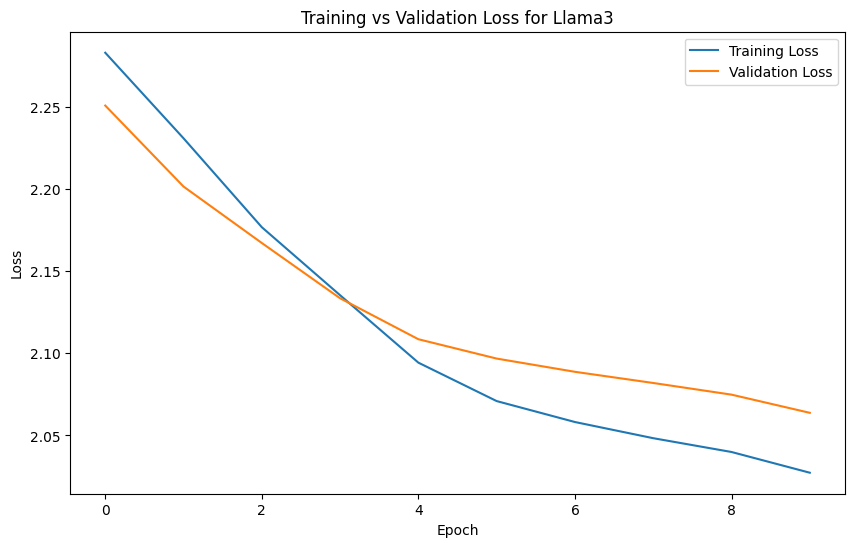

In [ ]:
# Training Loop
epochs = 10
accumulation_steps = 4  # Simulate larger batch size by accumulating gradients
progress_bar = tqdm(range(num_training_steps))

train_losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0
    llama_model.train()

    for i, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with autocast():
            outputs = llama_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(llama_model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            lr_scheduler.step()

        train_loss += loss.item() * accumulation_steps
        progress_bar.update(1)

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1} finished. Training Loss: {avg_train_loss}")

    # Validation Loop
    llama_model.eval()
    val_loss = 0
    decoded_preds = []
    decoded_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = llama_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            predictions = llama_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=300)

            decoded_pred = llama_tokenizer.batch_decode(predictions, skip_special_tokens=True)
            decoded_label = llama_tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds.extend(decoded_pred)
            decoded_labels.extend(decoded_label)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} finished. Validation Loss: {avg_val_loss}")

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss for Llama3")
plt.legend()
plt.show()

In [ ]:
# Evaluate with ROUGE Score
llama_model.eval()
test_decoded_preds = []
test_decoded_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        predictions = llama_model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=300)

        decoded_pred = llama_tokenizer.batch_decode(predictions, skip_special_tokens=True)
        decoded_label = llama_tokenizer.batch_decode(labels, skip_special_tokens=True)

        test_decoded_preds.extend(decoded_pred)
        test_decoded_labels.extend(decoded_label)

test_rouge_score = rouge.compute(predictions=test_decoded_preds, references=test_decoded_labels)
print(f"Test Data ROUGE Scores: {test_rouge_score}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Test Data ROUGE Scores: {'rouge1': 0.7595145890664179, 'rouge2': 0.7588283847109527, 'rougeL': 0.7594740357555048, 'rougeLsum': 0.7594953524285091}


It can be seen that for the test data, the fine-tuned GPT-2 model provided the best ROUGE results of ROUGE-1, equal to 76.619%, ROUGE-2, equal to 76.55% and ROUGE-L, equal to 76,61%. However, the loss curves indicated a slight tendency for the model overfitting

###Saving the fine-tuned models:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
output_dir = '/content/drive/MyDrive/Adv NLP/AT3/models/fine_tuned_llama3_model'
llama_model.save_pretrained(output_dir)
llama_tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

Mounted at /content/drive
Model and tokenizer saved to /content/drive/MyDrive/Adv NLP/AT3/models/fine_tuned_llama3_model


###References

Summarization. (n.d.). Huggingface.co. https://huggingface.co/docs/transformers/en/tasks/summarization